In [1]:
# 1. mounting google drive  
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# importing libraries
# https://nextjournal.com/gkoehler/pytorch-mnist
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
import torch 
import torchvision 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# setting random seed for pytorch and numpy for reproducible results
torch.manual_seed(10)
np.random.seed(0)


In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
#Get the shape of train and test loaders

train_shape = enumerate(train_loader)
idx, (train_data, train_targets) = next(train_shape)

test_shape = enumerate(test_loader)
idx, (test_data, test_targets) = next(test_shape)

In [6]:
print('The shape of the train and test data are {} and {}train_data.shape'.format(train_data.shape, test_data.shape))

The shape of the train and test data are torch.Size([64, 1, 28, 28]) and torch.Size([1000, 1, 28, 28])train_data.shape


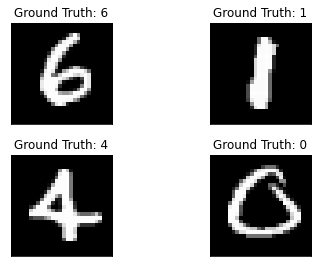

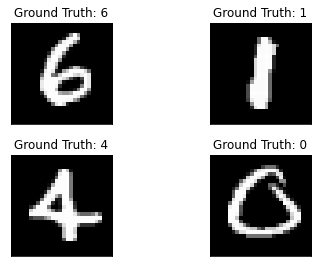

In [7]:
fig = plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

<Figure size 432x288 with 0 Axes>

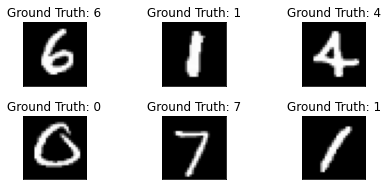

<Figure size 432x288 with 0 Axes>

In [8]:
num_plot = 6 #Make even number
for i in range(num_plot):
  plt.subplot(round(num_plot/2), round(num_plot/2), i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0], cmap='gray')
  plt.title('Ground Truth: {}'.format(train_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.figure()

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [60]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [61]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs+1)]

In [76]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      
      torch.save(network.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Computer_Vision/Computer_Vision_Tasks/mnist_cnn_b.pth')
      torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Computer_Vision/Computer_Vision_Tasks/optimizer.pth')
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [77]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [78]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0937, Accuracy: 9717/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.066954
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.273837
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.300393
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.395142
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.208131
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.390162
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.134753
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.174956
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.412536
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.215231
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.184730
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.306375
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.221187
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.341514
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.238826
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.193305
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.135065
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.207574
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.402246
Train Epoch: 1 [12160

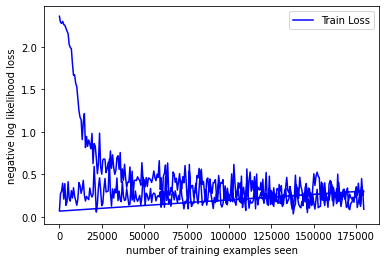

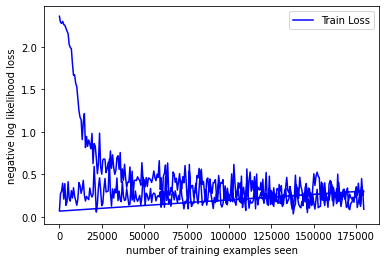

In [81]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [82]:
with torch.no_grad():
  output = network(test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


<Figure size 432x288 with 0 Axes>

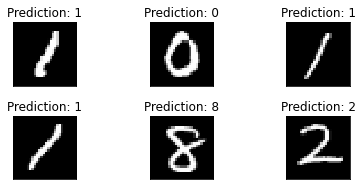

<Figure size 432x288 with 0 Axes>

In [83]:
num_plot = 6 #Make even number
for i in range(num_plot):
  plt.subplot(round(num_plot/2), round(num_plot/2), i+1)
  plt.tight_layout()
  plt.imshow(test_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.figure()

In [84]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [85]:
network_state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/Computer_Vision/Computer_Vision_Tasks/mnist_cnn_b.pth')
continued_network.load_state_dict(network_state_dict)


<All keys matched successfully>

In [88]:
optimizer_state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/Computer_Vision/Computer_Vision_Tasks/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)


In [89]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.152921
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.359545
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.280368
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.258771
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.162265
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.104237
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.184974
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.431195
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.238904
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.096883
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.195255
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.075885
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.219982
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.183128
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.227137
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.158782
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.188465
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.219025
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.329619
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.193942
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0642, Accuracy: 9812/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.087755
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.135637
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.107755
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.088140
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.181776
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.100897
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.093180
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.165111
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.127769
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.201910
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.291729
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.372956
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.067649
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.246153
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.179373
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.231662
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.313341
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.114631
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.085910
Train Epoch: 5 [12160